## Machine Learning - Support Vector Machine Example
### Kevin Jaggs Jan 2020

### Objective:
Train a Support Vector Machine (SVM) algorithm to an input training database. Starting with a default parameter SVC model, the aim is to tune hyperparameters and optimise classifier performance.

Outcomes at each stage will be scored using conventional binary classification scoring metrics.

### Method:

* Step 1 -  [Import the required python modules](#section_id_import_modules). Import of pandas dataframe, numpy, matplotlib and sklearn modules


* Step 2 -  [User selected parameters](#section_id_parameter). Options for user to select scoring criteria, cross validation number etc.


* Step 3 -  [Import Database_csv_to_pandas](#section_id_import_database). Import of database csv file to pandas dataframe. Note: the csv file is an independently formatted file, composed of random scoring criteria and the output column in last position [-1].


* Step 4 -  [Split dataset into test and train portions](#section_id_test_train_split). For conventional machine learning workflows, the input and output datasets are divided into training and testing sub-volumes. Algorithms are trained on the (not suprisingly) 'train' dataset and model outcomes are compared using the 'test' dataset, to prevent over-fitting.


* Step 5 -  [Feature scale input data](#section_id_feature_scale). Rescale the features/input columns such that they have the properties of a standard normal distribution with a mean of zero and a standard deviation of one.


* Step 6 -  [Fit default svm](#section_id_svm_raw). Fit a simple Linear Kernel SVM model using X_train_scaled. This output will provide a benchmark for any improvements noted in hyperparameter selection or feature selection.


* Step 7 - [Hyperparameter tuning with GridsearchCV](#section_id_gridsearchcv) Identify the best SVM model fit parameters using GridsearchCV


* Step 8 - [ROC curve comparison](#section_id_roc_curve) Comparison of the ROC curves for raw. GridsearchCV and RFE result models.


* Step 9 - [Precision Recall curve comparison](#section_id_pr_curve) Compare the precision recall curves for the raw, gridsearchcv and rfe models. Labels show the AUPR score.


* Step 10 - [Final model comparisons](#section_id_model_comparisons) Compare the outputs from all stages of the model evaluation: raw, gridsearchcv and rfecv.




### Dataset
A synthetic dataset with a binary outcome [0,1] in the last position. Most columns are discrete values [0,1,2,3,4,5] but some are continuous floats.
Note: the supplied input file is a conditioned, synthetic binary classification dataset i.e binary outcome of 0 or 1. You can simply add in a user selected database with the following preconditions: 1) Nan or empty cell values will be replaced with zero, 2) binary outcome only, 3) the results column is the last one [-1]. 

### Programming
This evaluation is performed using Python code and SKlearn provides the SVM classifier modules. 

At the time of script creation the following verions were used.
Python: 3.7.6
Numpy: 1.18.1
Pandas: 1.0.1
SKlearn: 0.22.1

### Outputs
* Fitted SVM models for default parameters (raw) and GridsearchCV hyperparameter tuning.
* Confusion matrix for Raw & GridsearchCV models.
* Accuracy, Precision, F1 or AUC scoring metric comparison for Raw & GridsearchCV.
* ROC_AUC plot for Raw & GridsearchCV models.
* AU_PR plot for Raw & GridsearchCV models.

<a id='section_id_import_modules'></a>

### 1. Import required Python Modules

In [1]:
print(__doc__)

#pandas dataframe - similar to a python version of excel. Most efficient way to perform data operations
import pandas as pd

#numpy for most mathematical operations
import numpy as np

#matplotlib for plotting functions
#import matplotlib.pyplot as plt
#from matplotlib.colors import ListedColormap
#seaborn for plotting heatmap
#import seaborn as sns

#sklearn for machine learning modules and scoring algorithms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, plot_confusion_matrix,classification_report

#recursice festure elimination
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold

#chi2 calculation
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import scipy

#plotting
import matplotlib.pyplot as plt

import sys
import sklearn
print("Python version: ", sys.version_info[0],".",sys.version_info[1],".",sys.version_info[2])
print("Numpy Version: " ,np.__version__)
print("Pandas Version: " ,pd.__version__)
print("Scikitlearn Version: " ,sklearn.__version__)

Automatically created module for IPython interactive environment
Python version:  3 . 7 . 6
Numpy Version:  1.18.1
Pandas Version:  1.0.1
Scikitlearn Version:  0.22.1


<a id='section_id_parameter'></a>

### 2. User selected parameters
Select scoring method, options of 'accuracy', 'precision', 'f1', 'roc_auc'
Crossvalidation fold i.e how many subsets the training data is split into for cross validation purposes, recommend value above 3 as this below this point overfits the data and will create a prediction error in the final assessment.


In [2]:
'''
Accuracy - ratio of correctly predicted observation to the total observations. 
Accuracy works best if false positives and false negatives have similar cost. 
Accuracy = TP+TN/TP+FP+FN+TN

Precision - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations.
High precision relates to the low false positive rate.
Precision = TP/TP+FP

Recall (Sensitivity) - Recall is the ratio of correctly predicted positive observations to the all observations in actual class
Recall = TP/TP+FN

F1 score - F1 Score is the weighted average of Precision and Recall. Takes both false pos and false neg into account. 
Use F1 if you have an uneven class distribution. 
If the cost of false positives and false negatives are very different - look at both Precision and Recall.
F1 Score = 2*(Recall * Precision) / (Recall + Precision)

roc_auc - the area under the receiver operating characteristic, plots the False Positive rate vs True Positive Rate for different thrshold cut offs.
The best models should plot towards the upper left quadrant of the plot, therefore calculating the area under the curve is a good measure of model performance.
'''

#score_cat = 'roc_auc'
score_cat = 'accuracy'
#score_cat = 'precision'
#score_cat = 'f1_score'

#plot labels are updated based upon 
if score_cat == 'roc_auc':
    plot_label = 'AUC'
if score_cat == 'accuracy':
    plot_label = 'Accuracy'
if score_cat == 'precision':
    plot_label = 'Precision' 
if score_cat == 'recall':
    plot_label = 'Recall'    
if score_cat == 'f1_score':
    plot_label = 'f1 score'  
    
#number of folds (equal data subsets) employed in cross validation - recommended to use above 4 for this dataset    
cross_validation_fold = 10    

#confidnce interval for chi2 calculation
conf_int = 0.95

#see random number generators - for repeatability
random_seed = 57

<a id='section_id_import_database'></a>

### 3. Import database csv file to pandas
The csv file is imported into a pandas dataframe, allowing ease of computation in later modules. All columns are considered numeric. The column header is the data category and the index is the row ID. There should be no Nan or empty cell values amd the output column is assumed to be in last column position.

In [3]:
def readcsvfile():
    '''
    (csv)->(pandas dataframe)
    routine to read import csv file to pandas
    comma separation, column headers = first row of text
    All column data is considered numeric
    Index = row 
    -999.25 values are converted to numpy NaN
    PRECONDITION: Import csv file is the correct format. All lines without a 1/0 output removed.
    KJAGGS June 2020
    '''
    
    #read csv file to pandas dataframe
    #df = pd.read_csv('classification_dataset.csv', encoding = 'utf-8',header=0,sep=',', index_col=0)
    df = pd.read_csv('classification_dataset.csv', encoding = 'utf-8',header=0,sep=',', index_col=0)

    #df = df.set_index('Row ID')
    df = df.apply(pd.to_numeric, errors='ignore')
    df = df.replace(-999.25,np.NaN)
    df = df.replace(np.NaN,0)
    #print(df.isnull().any())
    return df

df = readcsvfile()

###optional qc features - remove hash/# to view 
#print(df.head)
#print(df.columns.tolist)


print("Dataframe size on import")
print("Number of prospects :", df.shape[0])
print("Number of data categories :", df.shape[1])

print("\nProportion (%) of Success:Fail outcomes")
print("1 = Success")
print("0 = Fail")
print(df.iloc[:, -1].value_counts(normalize=True) * 100)



Dataframe size on import
Number of prospects : 352
Number of data categories : 43

Proportion (%) of Success:Fail outcomes
1 = Success
0 = Fail
1    53.125
0    46.875
Name: Output Class, dtype: float64


<a id='section_id_test_train_split'></a>

### 4. Split into test and train datasets
Data is divided into test and training sub-volumes for the purpose of fitting models and preventing over-fitting/bias issues. The current defaults in the module below are to split 80:20 train:test. No random number seeding, no shuffling of input data and no stratifying (equal proportions of success/fail  outcomes in each sub-volume). These faetures are adjusted at the bottom of the next cell as the input to function; user can change accordingly.

In [4]:
def training_split(Xdata, Ydata, test_size=0.2,stratify=None,random_state=None,shuffle=False):
    '''
    (DataframeXColumns)(DataframeYColumn)=>(array)(array)(array)(array)
    For the purposes of splitting x and y data into test and training sets
    train_test_split is currently set to default settings
    PRECONDITION: Input datasets are formatted correctly
    KJAGGS June2020
    '''

    #split the data - default settings for now
    X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=test_size,stratify=stratify, random_state = random_state, shuffle = shuffle)

    #resize the output data sets if a 1 column vector, now compatible  with regression modules
    if len(X_train.shape) <2:  
       X_train = X_train.ravel()
    if len(y_train.shape) <2:  
       y_train = y_train.ravel()
    if len(X_test.shape) <2:  
       X_test = X_test.ravel()
    if len(y_train.shape) <2:  
       y_test = y_test.ravel()
    
    return X_train, X_test, y_train, y_test

#print(df.columns.tolist())
#output dataset is success/fail only
print(df.shape)

#remove result column from input dataset
y = df[df.columns[-1]]

#X = df.drop(df.columns[[-1]], axis=1)
#X = df.drop(df.columns[[1,-1]], axis=1)
X = df.drop(df.columns[[0,1,-1]], axis=1)



#split the datasets
#Shuffle = randomly shuffle the data before, If shuffle=False then stratify must be None.
#random state = seeding of random numbers for reproducibility across various modules
#stratify = ensure proportion of outcomes are the same across both datasets i.e % of successes in train = % of successes in test
X_train, X_test, y_train, y_test = training_split(X,y,shuffle=True,random_state=random_seed,stratify=y,test_size=0.25)

print("Train and test dataset sizes")
print("Training dataset size :", X_train.shape)
print("Test dataset size :", X_test.shape)

(352, 43)
Train and test dataset sizes
Training dataset size : (264, 40)
Test dataset size : (88, 40)


<a id='section_id_feature_scale'></a>

### 5. Feature scale the input data
Input independent variables are scaled so that the the attribute mean is zero with a unit standard deviation. Gradient descent algorithms (neural networks, for example) run more efficiently if input tfeatures are scaled accordingly. decision tree methods are invariant to scaling.

In [5]:
#set up scaler - StandardScaler from SciKit learn
#Standardize features by removing the mean and scaling to unit variance
#z = (x - u) / s
scaler = StandardScaler()

#scaler is calculated on the train data ONLY. Would be considered data leakage - test data must not influence the model output.
scaler.fit(X_train)

#apply the scaler to the train and test datasets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


<a id='section_id_svm_raw'></a>

### 6. Fit default SVM model
A default RBF Kernel model is fitted to the training data to create a benchmark upon which future outputs of hyperparameter tuning or feature selction methods will be judged on. 


              precision    recall  f1-score   support

           0       0.71      0.54      0.61        41
           1       0.67      0.81      0.73        47

    accuracy                           0.68        88
   macro avg       0.69      0.67      0.67        88
weighted avg       0.69      0.68      0.68        88



Text(0.5, 1.0, 'Confusion matrix - default parameters, scoring = accuracy')

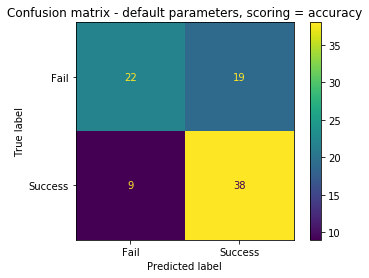

In [6]:
#Create a svm Classifier
clf_raw = SVC(kernel='rbf',probability=True,random_state=100) # Linear Kernel

#Train the model using the training sets
clf_raw.fit(X_train_scaled, y_train)

#Predict the response for test dataset
#_raw suffix is used to identify this model in the final model reviews
y_pred_raw = clf_raw.predict(X_test_scaled)

#y_score_raw = clf_raw.predict_proba(X_test_scaled)
#retains positive values only
y_score_raw = clf_raw.predict_proba(X_test_scaled)[:,1]

#print("Accuracy =", accuracy_score(y_test, y_pred_raw))
#print("Precision =", precision_score(y_test, y_pred_raw))
#print('f1 = {:.2f}'.format(f1_score(y_test, y_pred_raw)))
#print("AUC =", roc_auc_score(y_test, y_pred_raw))

# print classification report 
print(classification_report(y_test, y_pred_raw)) 

#confusion matrix plot
disp = plot_confusion_matrix(clf_raw,X_test_scaled,y_test, display_labels=["Fail","Success"])
#set confusion matrix plot
disp.ax_.set_title('Confusion matrix - default parameters, scoring = ' + score_cat)

#print(title)
#print(disp.confusion_matrix)


<a id='section_id_gridsearchcv'></a>

### 7 Tune Hyperparameters using GridsearchCV
Use the sklearn function of GridsearchCV to find which parameters provide the best model fit when predicting the X_test_scaled dataset

In [ ]:
# Set the parameters by cross-validation

tuned_parameters = {'C': [0.001,0.005,0.01,0.05,0.1,0.5,1,1,5,2,2.5,3,4,5], 'gamma': [1,0.1,0.05,0.01,0.005, 0.001],'kernel': ['rbf', 'poly', 'sigmoid']}


#set up the Gridserch model
#cross validation fold is specified in section 2
clf_cv = GridSearchCV(SVC(probability=True), tuned_parameters, refit = True,cv = StratifiedKFold(cross_validation_fold), scoring = score_cat) 
  
# fitting the model for grid search 
clf_cv.fit(X_train_scaled, y_train) 


#option to print out scores of cross validation fold data
#means = clf_cv.cv_results_['mean_test_score']
#stds = clf_cv.cv_results_['std_test_score']
#for mean, std, params in zip(means, stds, clf_cv.cv_results_['params']):
#    print("%0.3f (+/-%0.03f) for %r"
#          % (mean, std * 2, params)) 
 
#predictions based upon the x_test dataset using the recommended model fit    
y_pred_gridcv = clf_cv.predict(X_test_scaled) 
   
y_score_gridcv = clf_cv.predict_proba(X_test_scaled)[:,1]    
#retains positive values only
#y_score_gridcv = clf_cv.predict_proba(X_test_scaled)[:,1]
    

print("Best parameters for scoring category : ", score_cat)
print(clf_cv.best_params_) 

#display classification report
print("\nClassiciation Report:\n",classification_report(y_test, y_pred_gridcv)) 

#plot the confusion matrix - visual qc with colour fill
disp = plot_confusion_matrix(clf_cv,X_test_scaled,y_test, display_labels=["Fail","Success"])
#set confusion matrix plot
disp.ax_.set_title('Confusion matrix - GridsearchCV, scoring = ' + score_cat)


<a id='section_id_roc_curve'></a>

### 8 Receiver Operating Character (ROC) curve
Compare the roc curves for the raw, gridsearchcv, rfe and chi2 models. Labels show the AUC score.

In [ ]:
#ROC AUC Curve Generation for final optimised model
false_positive_raw, true_positive_raw, threshold_raw = roc_curve(y_test, y_score_raw)

#ROC AUC Curve Generation for final optimised model
false_positive_gridcv, true_positive_gridcv, threshold_tuned_feature = roc_curve(y_test, y_score_gridcv)

raw_auc_label = "raw, AUC = {:.2f}".format(roc_auc_score(y_test, y_score_raw))
gridcv_auc_label = "gridCV, AUC = {:.2f}".format(roc_auc_score(y_test, y_score_gridcv))

#Plot ROC Curve
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Linear SVM: Scoring = ' + score_cat)
plt.plot(false_positive_raw, true_positive_raw, label=raw_auc_label)
plt.plot(false_positive_gridcv, true_positive_gridcv, label=gridcv_auc_label)
plt.plot([0, 1], ls="--", label='Baseline')
plt.plot([0, 0], [1, 0] , c=".2"), plt.plot([1, 1] , c=".2",label="Perfect classifier")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.show()

#print('roc_auc_score for Linear SVM: ', roc_auc_score(y_test, y_score_tuned_feature))

<a id='section_id_pr_curve'></a>

### 9 Precision Recall (PR) curve
Compare the precision recall curves for the raw, gridsearchcv, rfe and chi2 models. Labels show the AUPR score.

In [ ]:
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


#AUPR Curve Generation for raw model
prec_raw, recall_raw, threshold_pr_raw = precision_recall_curve(y_test, y_score_raw)

#AUPR Curve Generation for gridsearch cv model
prec_gridcv, recall_gridcv, threshold_pr_tuned_feature = precision_recall_curve(y_test, y_score_gridcv)

raw_pr_label = "raw, AUPR = {:.2f}".format(average_precision_score(y_test, y_score_raw))
gridcv_pr_label = "gridCV, AUPR = {:.2f}".format(average_precision_score(y_test, y_score_gridcv))

baseline = len(y_test[y_test==1]) / len(y_test)
# plot the no skill precision-recall curve


#Plot Precision Recall Curve
plt.subplots(1, figsize=(10,10))
plt.title('Precision Recall Curve - Linear SVM: Scoring = ' + score_cat)
plt.plot( recall_raw,prec_raw, label=raw_pr_label)
plt.plot( recall_gridcv,prec_gridcv, label=gridcv_pr_label)
plt.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
plt.plot([0, 1], [1, 1] , c=".2"), plt.plot([1, 1] , [1, 0], c=".2",label="perfect classifier")
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc="lower right")
plt.show()


<a id='section_id_model_comparisons'></a>

### 10 Final model comparisons
Compare the outputs from all stages of the model evaluation: raw, gridsearchcv and rfecv.

In [ ]:
def summary_scores(y_test_summary, y_pred_summary, y_score_summary):
    
    print('Accuracy score on test set: {:.2f}'.format(accuracy_score(y_test_summary, y_pred_summary)))
    print('Precision score on test set: {:.2f}'.format(precision_score(y_test_summary, y_pred_summary)))
    print('Recall score on test set: {:.2f}'.format(recall_score(y_test_summary, y_pred_summary)))
    print('Micro f1  score on test set: {:.2f}'.format(f1_score(y_test_summary, y_pred_summary, average='micro')))
    print('Macro f1  score on test set: {:.2f}'.format(f1_score(y_test_summary, y_pred_summary, average='macro')))
    print('Weighted f1  score on test set: {:.2f}'.format(f1_score(y_test_summary, y_pred_summary, average='weighted')))
    print("AUC  on test set: {:.2f}".format(roc_auc_score(y_test_summary, y_score_summary)))
    print("\n")

print("\nSupport Vector Machine: Default parameters\n")    
summary_scores(y_test, y_pred_raw, y_score_raw)

print("Support Vector Machine: Gridsearch\n")
summary_scores(y_test, y_pred_gridcv, y_score_gridcv)

